# SN-GAN Training

This notebook demonstrates training a Spectral Normalization GAN (SN-GAN) on various datasets like shape3d, cars3d, dsprites 

The SN-GAN uses spectral normalization in the discriminator to control the Lipschitz constant, leading to more stable training compared to vanilla GANs.

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Add the project root to the path to import our modules
sys.path.append('jupyter NBs/GAN (Tests)')

# Import our custom modules
from datasets.shapes3d import Shapes3D
from gan.trainer import GANTrainer
from gan.architecture import Generator, Discriminator
from gan.loss import get_loss
from gan.utils import show_dataset_samples, free_memory, set_random_seeds

# Set up device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Memory cleanup utility - now using imported function from utils
# Example: call after training (you can also call manually later)
free_memory()

RAM and CUDA memory have been freed.


In [3]:
# Set random seeds for reproducibility - now using imported function from utils
seed_number = 42
set_random_seeds(seed_number)

Random seeds set to 42 for reproducibility.


# Shapes3d

In [ ]:
# SN-GAN Configuration
print("Setting up SN-GAN trainer...")

# Model hyperparameters
latent_dim = 10
img_size = (3, 64, 64)  # C, H, W
learning_rate_g = 1e-4
learning_rate_d = 1e-4
beta1 = 0.5  # SN-GAN typically uses beta1=0.5 for Adam
beta2 = 0.999

# SN-GAN specific parameters
lambda_sn = 10.0  # SN loss coefficient

# Create models explicitly (no more defaults inside GANTrainer)
generator = Generator(latent_dim=latent_dim, img_size=img_size, use_batchnorm=True, negative_slope=0.1, output_activation='sigmoid')
# SN-GAN uses spectral normalization
discriminator = Discriminator(img_size=img_size, use_spectral_norm=True)

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Create optimizers explicitly
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(beta1, beta2))

# Create SN-GAN trainer (now requires models and optimizers)
trainer = GANTrainer(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    loss_type='sngan',  # Spectral Norm loss
    loss_kwargs={'lambda_sn': lambda_sn},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created")
print(f"Generator parameters: {sum(p.numel() for p in trainer.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer.discriminator.parameters()):,}")
print(f"Loss type: {trainer.loss_type}")
print(f"SN loss coefficient (λ_sn): {lambda_sn}")
print(f"Device: {trainer.device}")

Setting up Shapes3D dataset...
Dataset loaded with 480000 images
Image size: (3, 64, 64)
Selected factors: ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
DataLoader created with batch size: 64
Number of batches: 7500


Sample images from the Shapes3D dataset:


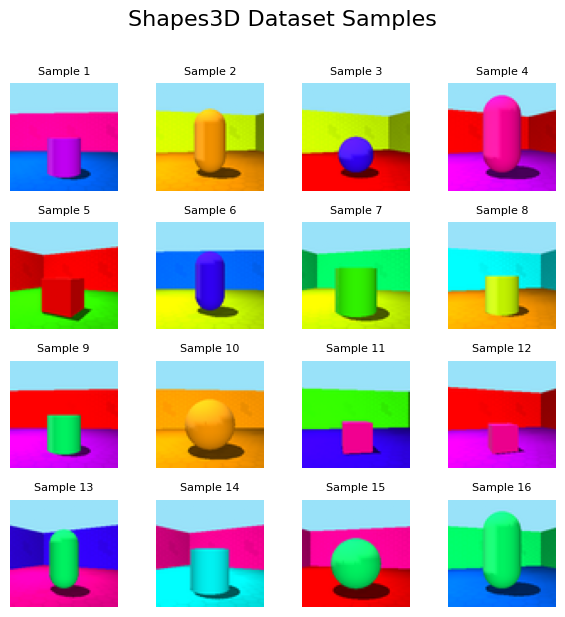

In [5]:
# Visualize some sample data
print("Sample images from the Shapes3D dataset:")
show_dataset_samples(dataset, n_samples=16, title='Shapes3D Dataset Samples')

In [ ]:
# SN-GAN Configuration for DSprites
print("Setting up SN-GAN trainer for DSprites...")

# Model hyperparameters for DSprites (grayscale images)
latent_dim_dsprites = 10
img_size_dsprites = (1, 64, 64)  # Grayscale images (1 channel)
learning_rate_g_dsprites = 1e-4
learning_rate_d_dsprites = 1e-4
beta1_dsprites = 0.5  # SN-GAN typically uses beta1=0.5
beta2_dsprites = 0.999

# SN-GAN specific parameters
lambda_sn_dsprites = 10.0  # SN loss coefficient

# Create models for DSprites (1-channel input)
generator_dsprites = Generator(latent_dim=latent_dim_dsprites, img_size=img_size_dsprites, output_activation='sigmoid')
# SN-GAN uses spectral normalization
discriminator_dsprites = Discriminator(img_size=img_size_dsprites, use_spectral_norm=True)

# Move models to device
generator_dsprites = generator_dsprites.to(device)
discriminator_dsprites = discriminator_dsprites.to(device)

# Create optimizers
g_optimizer_dsprites = optim.Adam(generator_dsprites.parameters(), lr=learning_rate_g_dsprites, betas=(beta1_dsprites, beta2_dsprites))
d_optimizer_dsprites = optim.Adam(discriminator_dsprites.parameters(), lr=learning_rate_d_dsprites, betas=(beta1_dsprites, beta2_dsprites))

# Create SN-GAN trainer for DSprites
trainer_dsprites = GANTrainer(
    generator=generator_dsprites,
    discriminator=discriminator_dsprites,
    g_optimizer=g_optimizer_dsprites,
    d_optimizer=d_optimizer_dsprites,
    loss_type='sngan',  # Spectral Norm loss
    loss_kwargs={'lambda_sn': lambda_sn_dsprites},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created for DSprites")
print(f"Generator parameters: {sum(p.numel() for p in trainer_dsprites.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_dsprites.discriminator.parameters()):,}")
print(f"Loss type: {trainer_dsprites.loss_type}")
print(f"SN loss coefficient (λ_sn): {lambda_sn_dsprites}")
print(f"Device: {trainer_dsprites.device}")
print(f"Image size: {img_size_dsprites}")

Setting up SN-GAN trainer...
SN-GAN trainer created
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: sngan
Device: cuda


In [7]:
# Training Configuration
epochs = 1  # Adjust based on your computational resources

# Option 1: Train by epochs (existing functionality)
trainer.train(dataloader, epochs=epochs)

# Option 2: Train by iterations (new functionality)
# You can also train by specifying total iterations instead of epochs
# This gives you precise control over training duration regardless of dataset size
# Example:
# total_iterations = epochs * len(dataloader)  # equivalent to the epochs above
# trainer.train(dataloader, total_iterations=total_iterations)
# 
# Or train for a specific number of iterations:
# trainer.train(dataloader, total_iterations=1000)  # train for exactly 1000 iterations

Training for 1 epochs (7500 iterations)...
Starting training for 7500 iterations...
Loss type: sngan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 7500/7500 [01:57<00:00, 63.93it/s, D_loss=0.4129, G_loss=1.2776, Epoch=0.0]


Training completed!


(0.23760372632133464, 1.4832307836132435)

Plotting training losses...


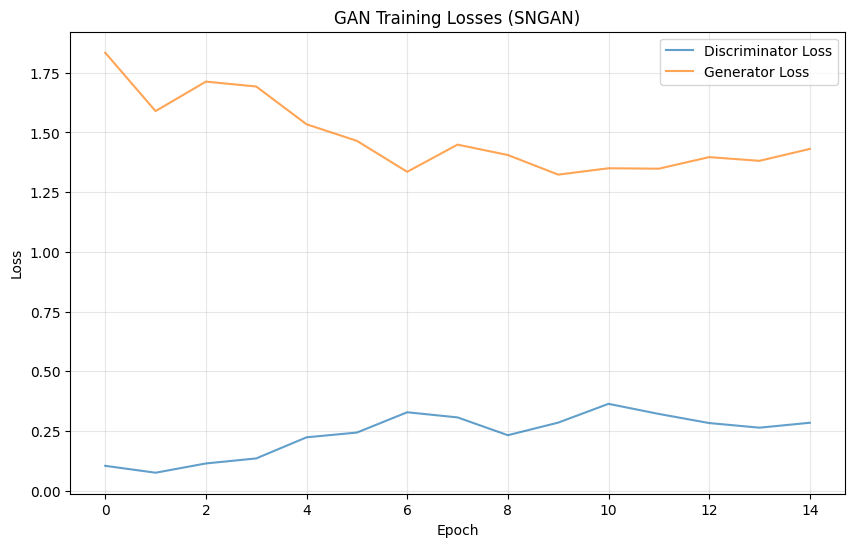


Training Summary:
Final Discriminator Loss: 0.2844
Final Generator Loss: 1.4311
Average Discriminator Loss: 0.2376
Average Generator Loss: 1.4832


In [8]:
# Visualize Training Progress
print("Plotting training losses...")
trainer.plot_losses()

# Show training history summary
if trainer.history['d_loss'] and trainer.history['g_loss']:
    print(f"\nTraining Summary:")
    print(f"Final Discriminator Loss: {trainer.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN...


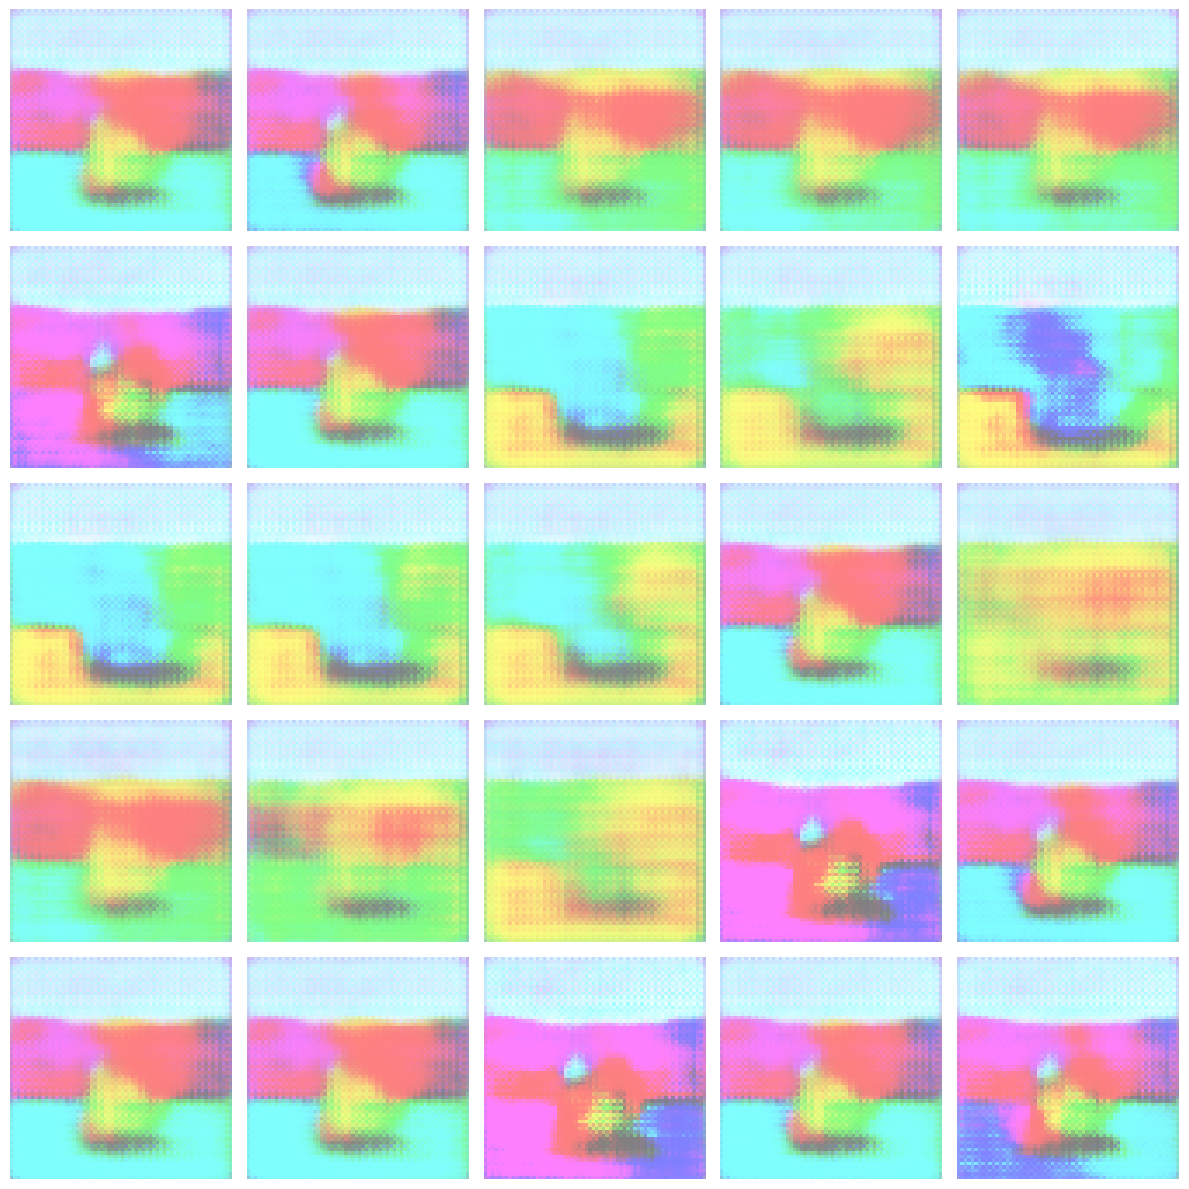

In [10]:
# Generate and Display Sample Images
print("Generating sample images from trained SN-GAN...")
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# dsprites

In [ ]:
# SN-GAN Configuration for Cars3D
print("Setting up SN-GAN trainer for Cars3D...")

# Model hyperparameters for Cars3D (RGB images, same as Shapes3D)
latent_dim_cars3d = 10
img_size_cars3d = (3, 64, 64)  # RGB images (3 channels)
learning_rate_g_cars3d = 1e-4
learning_rate_d_cars3d = 1e-4
beta1_cars3d = 0.5  # SN-GAN typically uses beta1=0.5
beta2_cars3d = 0.999

# SN-GAN specific parameters
lambda_sn_cars3d = 10.0  # SN loss coefficient

# Create models for Cars3D (3-channel RGB input, same as Shapes3D)
generator_cars3d = Generator(latent_dim=latent_dim_cars3d, img_size=img_size_cars3d, use_batchnorm=True, negative_slope=0.2, output_activation='sigmoid')
# SN-GAN uses spectral normalization
discriminator_cars3d = Discriminator(img_size=img_size_cars3d, use_spectral_norm=True)

# Move models to device
generator_cars3d = generator_cars3d.to(device)
discriminator_cars3d = discriminator_cars3d.to(device)

# Create optimizers
g_optimizer_cars3d = optim.Adam(generator_cars3d.parameters(), lr=learning_rate_g_cars3d, betas=(beta1_cars3d, beta2_cars3d))
d_optimizer_cars3d = optim.Adam(discriminator_cars3d.parameters(), lr=learning_rate_d_cars3d, betas=(beta1_cars3d, beta2_cars3d))

# Create SN-GAN trainer for Cars3D
trainer_cars3d = GANTrainer(
    generator=generator_cars3d,
    discriminator=discriminator_cars3d,
    g_optimizer=g_optimizer_cars3d,
    d_optimizer=d_optimizer_cars3d,
    loss_type='sngan',  # Spectral Norm loss
    loss_kwargs={'lambda_sn': lambda_sn_cars3d},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created for Cars3D")
print(f"Generator parameters: {sum(p.numel() for p in trainer_cars3d.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_cars3d.discriminator.parameters()):,}")
print(f"Loss type: {trainer_cars3d.loss_type}")
print(f"SN loss coefficient (λ_sn): {lambda_sn_cars3d}")
print(f"Device: {trainer_cars3d.device}")
print(f"Image size: {img_size_cars3d}")

Setting up DSprites dataset...
DSprites dataset loaded with 40960 images
Image size: (1, 64, 64)
Selected factors: ['orientation', 'posX', 'posY']
DataLoader created with batch size: 64
Number of batches: 640


Sample images from the DSprites dataset:


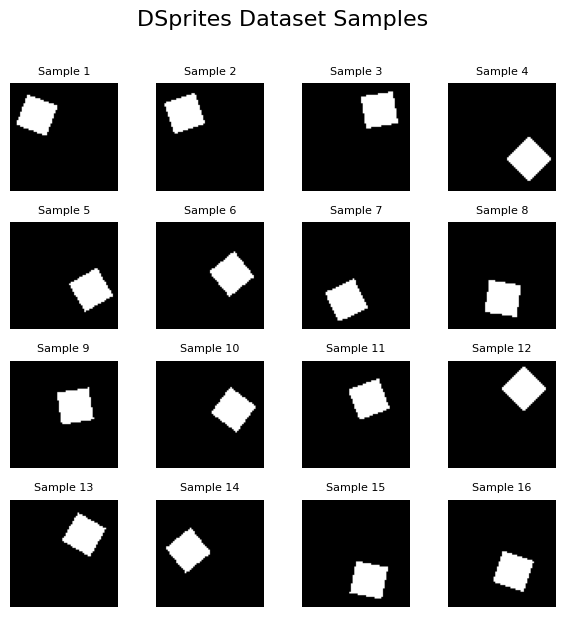

In [12]:
# Visualize some sample data from DSprites
print("Sample images from the DSprites dataset:")
show_dataset_samples(dataset_dsprites, n_samples=16, title='DSprites Dataset Samples')

In [13]:
# SN-GAN Configuration for DSprites
print("Setting up SN-GAN trainer for DSprites...")

# Model hyperparameters for DSprites (grayscale images)
latent_dim_dsprites = 10
img_size_dsprites = (1, 64, 64)  # Grayscale images (1 channel)
learning_rate_g_dsprites = 1e-4
learning_rate_d_dsprites = 1e-4
beta1_dsprites = 0.9
beta2_dsprites = 0.999

# Create models for DSprites (1-channel input)
generator_dsprites = Generator(latent_dim=latent_dim_dsprites, img_size=img_size_dsprites)
# Enable spectral normalization in the discriminator for SN-GAN
discriminator_dsprites = Discriminator(img_size=img_size_dsprites, use_spectral_norm=True)

# Move models to device
generator_dsprites = generator_dsprites.to(device)
discriminator_dsprites = discriminator_dsprites.to(device)

# Create optimizers
g_optimizer_dsprites = optim.Adam(generator_dsprites.parameters(), lr=learning_rate_g_dsprites, betas=(beta1_dsprites, beta2_dsprites))
d_optimizer_dsprites = optim.Adam(discriminator_dsprites.parameters(), lr=learning_rate_d_dsprites, betas=(beta1_dsprites, beta2_dsprites))

# Create SN-GAN trainer for DSprites
trainer_dsprites = GANTrainer(
    generator=generator_dsprites,
    discriminator=discriminator_dsprites,
    g_optimizer=g_optimizer_dsprites,
    d_optimizer=d_optimizer_dsprites,
    loss_type='sngan',  # hinge loss
    loss_kwargs={},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created for DSprites")
print(f"Generator parameters: {sum(p.numel() for p in trainer_dsprites.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_dsprites.discriminator.parameters()):,}")
print(f"Loss type: {trainer_dsprites.loss_type}")
print(f"Device: {trainer_dsprites.device}")
print(f"Image size: {img_size_dsprites}")

Setting up SN-GAN trainer for DSprites...
SN-GAN trainer created for DSprites
Generator parameters: 381,697
Discriminator parameters: 378,049
Loss type: sngan
Device: cuda
Image size: (1, 64, 64)


In [14]:
# Training Configuration for DSprites
epochs_dsprites = 20  # Adjust based on your computational resources
print(f"Starting SN-GAN training on DSprites for {epochs_dsprites} epochs...")

# Option 1: Train by epochs (existing functionality)
trainer_dsprites.train(dataloader_dsprites, epochs=epochs_dsprites)

# Option 2: Train by iterations (new functionality)
# Alternative approach - train by specifying total iterations
# total_iterations = epochs_dsprites * len(dataloader_dsprites)
# trainer_dsprites.train(dataloader_dsprites, total_iterations=total_iterations)
#
# Or train for a fixed number of iterations regardless of dataset size:
# trainer_dsprites.train(dataloader_dsprites, total_iterations=5000)
#
# You can also specify custom log intervals for iteration-based training:
# trainer_dsprites.train(dataloader_dsprites, total_iterations=5000, log_interval=500)

print("DSprites training completed!")

Starting SN-GAN training on DSprites for 20 epochs...
Training for 20 epochs (12800 iterations)...
Starting training for 12800 iterations...
Loss type: sngan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 12800/12800 [03:28<00:00, 61.44it/s, D_loss=1.3978, G_loss=0.3646, Epoch=19.0]


Training completed!
DSprites training completed!


Plotting DSprites training losses...


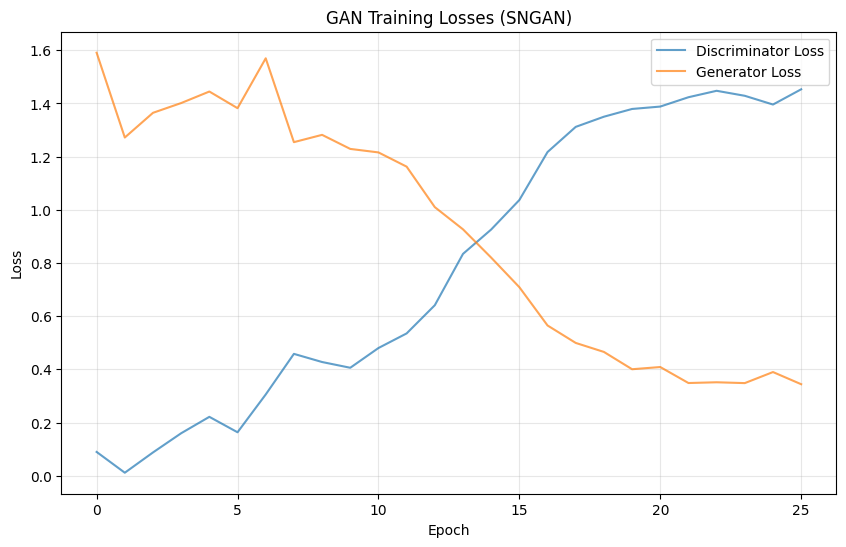


DSprites Training Summary:
Final Discriminator Loss: 1.4530
Final Generator Loss: 0.3442
Average Discriminator Loss: 0.7915
Average Generator Loss: 0.9137


In [15]:
# Visualize DSprites Training Progress
print("Plotting DSprites training losses...")
trainer_dsprites.plot_losses()

# Show training history summary for DSprites
if trainer_dsprites.history['d_loss'] and trainer_dsprites.history['g_loss']:
    print(f"\nDSprites Training Summary:")
    print(f"Final Discriminator Loss: {trainer_dsprites.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer_dsprites.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer_dsprites.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer_dsprites.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN on DSprites...


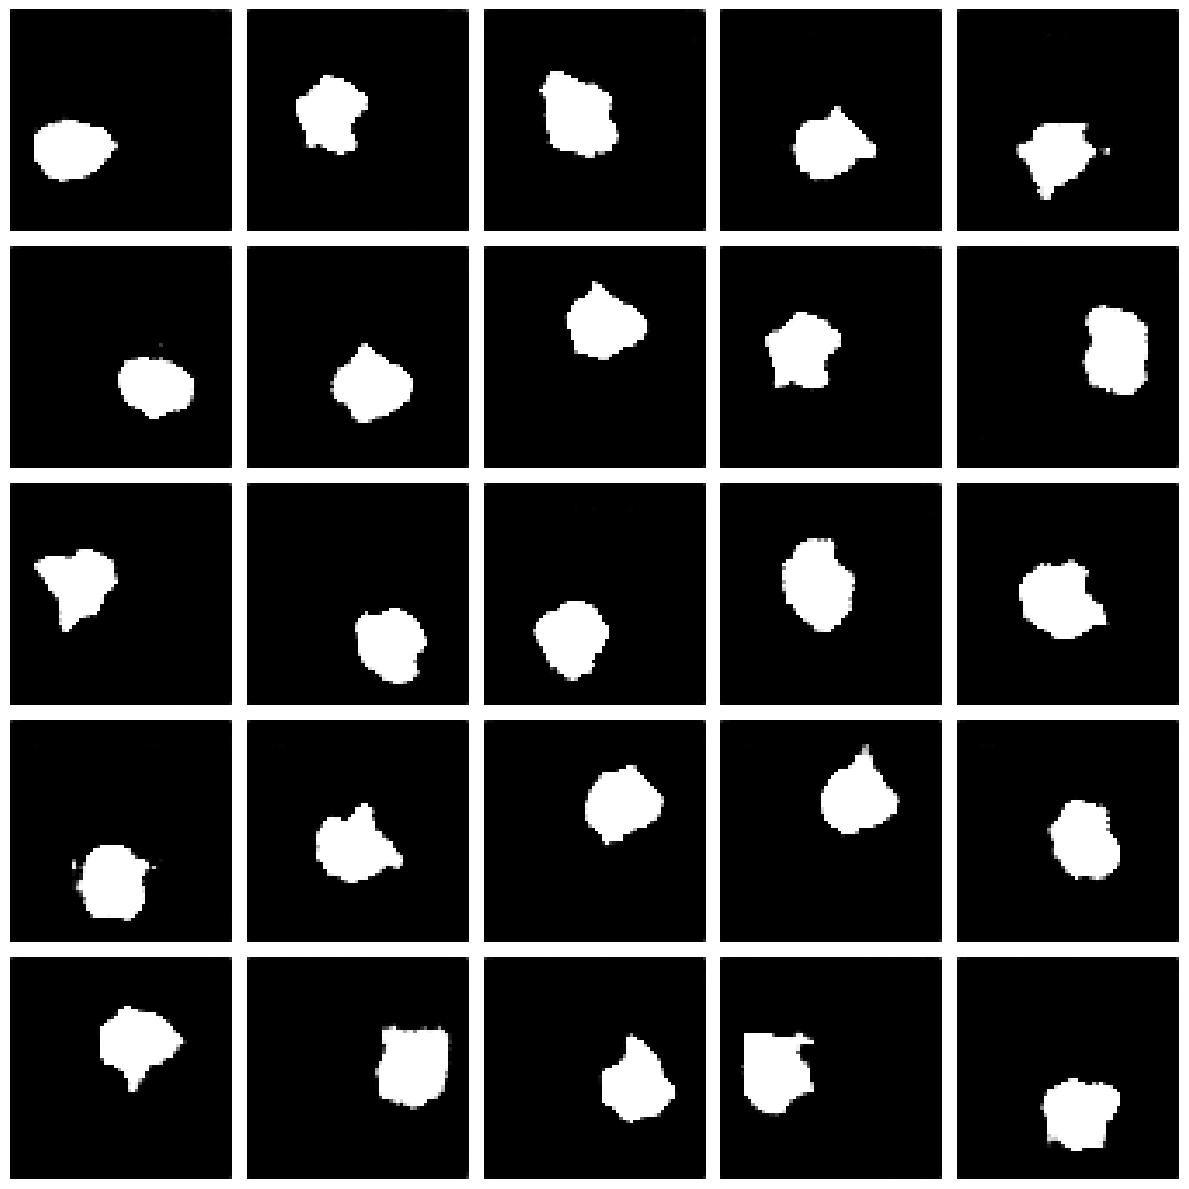

In [20]:
# Generate and Display Sample Images from DSprites SN-GAN
print("Generating sample images from trained SN-GAN on DSprites...")
trainer_dsprites.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# cars3d

In [21]:
# Dataset Configuration for Cars3D
print("Setting up Cars3D dataset...")

# Import Cars3D dataset
from datasets.cars3d import Cars3D

# For Cars3D, we'll select all factors to show the full diversity
# Cars3D factors: ('elevation', 'azimuth', 'object_type')
selected_factors = ['elevation', 'azimuth', 'object_type']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors

root = 'data/cars3d/'  # Local path for cars3d dataset

# Create dataset instance
dataset_cars3d = Cars3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Cars3D dataset loaded with {len(dataset_cars3d)} images")
print(f"Image size: {dataset_cars3d.img_size}")
print(f"Selected factors: {dataset_cars3d.selected_factors}")

# Create DataLoader
batch_size_cars3d = 64
dataloader_cars3d = DataLoader(
    dataset_cars3d, 
    batch_size=batch_size_cars3d, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size_cars3d}")
print(f"Number of batches: {len(dataloader_cars3d)}")

Setting up Cars3D dataset...
Cars3D dataset loaded with 17568 images
Image size: (3, 64, 64)
Selected factors: ['elevation', 'azimuth', 'object_type']
DataLoader created with batch size: 64
Number of batches: 275
Cars3D dataset loaded with 17568 images
Image size: (3, 64, 64)
Selected factors: ['elevation', 'azimuth', 'object_type']
DataLoader created with batch size: 64
Number of batches: 275


Sample images from the Cars3D dataset:


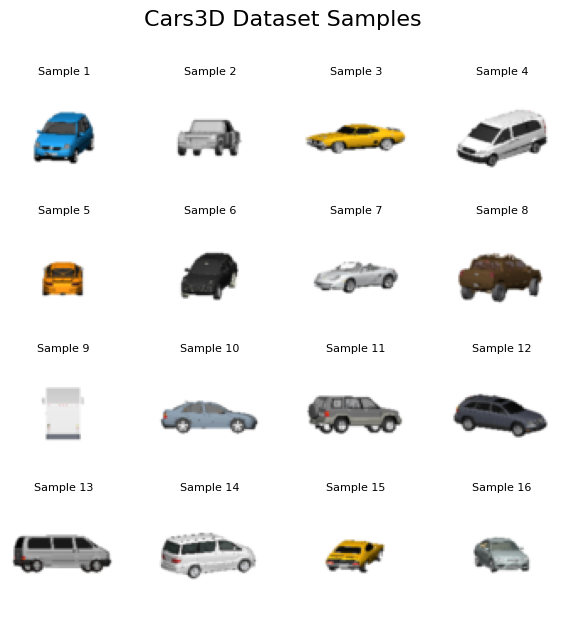

In [22]:
# Visualize some sample data from Cars3D
print("Sample images from the Cars3D dataset:")
show_dataset_samples(dataset_cars3d, n_samples=16, title='Cars3D Dataset Samples')

In [23]:
# SN-GAN Configuration for Cars3D
print("Setting up SN-GAN trainer for Cars3D...")

# Model hyperparameters for Cars3D (RGB images, same as Shapes3D)
latent_dim_cars3d = 10
img_size_cars3d = (3, 64, 64)  # RGB images (3 channels)
learning_rate_g_cars3d = 1e-4
learning_rate_d_cars3d = 1e-4
beta1_cars3d = 0.9
beta2_cars3d = 0.999

# Create models for Cars3D (3-channel RGB input, same as Shapes3D)
generator_cars3d = Generator(latent_dim=latent_dim_cars3d, img_size=img_size_cars3d, use_batchnorm=True, negative_slope=0.2)
# Enable spectral normalization in the discriminator for SN-GAN
discriminator_cars3d = Discriminator(img_size=img_size_cars3d, use_spectral_norm=True)

# Move models to device
generator_cars3d = generator_cars3d.to(device)
discriminator_cars3d = discriminator_cars3d.to(device)

# Create optimizers
g_optimizer_cars3d = optim.Adam(generator_cars3d.parameters(), lr=learning_rate_g_cars3d, betas=(beta1_cars3d, beta2_cars3d))
d_optimizer_cars3d = optim.Adam(discriminator_cars3d.parameters(), lr=learning_rate_d_cars3d, betas=(beta1_cars3d, beta2_cars3d))

# Create SN-GAN trainer for Cars3D
trainer_cars3d = GANTrainer(
    generator=generator_cars3d,
    discriminator=discriminator_cars3d,
    g_optimizer=g_optimizer_cars3d,
    d_optimizer=d_optimizer_cars3d,
    loss_type='sngan',  # hinge loss
    loss_kwargs={},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created for Cars3D")
print(f"Generator parameters: {sum(p.numel() for p in trainer_cars3d.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_cars3d.discriminator.parameters()):,}")
print(f"Loss type: {trainer_cars3d.loss_type}")
print(f"Device: {trainer_cars3d.device}")
print(f"Image size: {img_size_cars3d}")

Setting up SN-GAN trainer for Cars3D...
SN-GAN trainer created for Cars3D
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: sngan
Device: cuda
Image size: (3, 64, 64)


In [27]:
# Training Configuration for Cars3D
epochs_cars3d = 100  # Adjust based on your computational resources
print(f"Starting SN-GAN training on Cars3D for {epochs_cars3d} epochs...")

# Option 1: Train by epochs (existing functionality)
trainer_cars3d.train(dataloader_cars3d, epochs=epochs_cars3d)

# Option 2: Train by iterations (new functionality)
# Alternative approach - train by specifying total iterations
# total_iterations = epochs_cars3d * len(dataloader_cars3d)
# trainer_cars3d.train(dataloader_cars3d, total_iterations=total_iterations)
#
# Or train for a fixed number of iterations regardless of dataset size:
# trainer_cars3d.train(dataloader_cars3d, total_iterations=5000)
#
# You can also specify custom log intervals for iteration-based training:
# trainer_cars3d.train(dataloader_cars3d, total_iterations=5000, log_interval=500)

print("Cars3D training completed!")

Starting SN-GAN training on Cars3D for 100 epochs...
Training for 100 epochs (27500 iterations)...
Starting training for 27500 iterations...
Loss type: sngan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 27500/27500 [07:47<00:00, 58.78it/s, D_loss=1.8792, G_loss=0.6729, Epoch=99.0] 


Training completed!
Cars3D training completed!


Plotting Cars3D training losses...


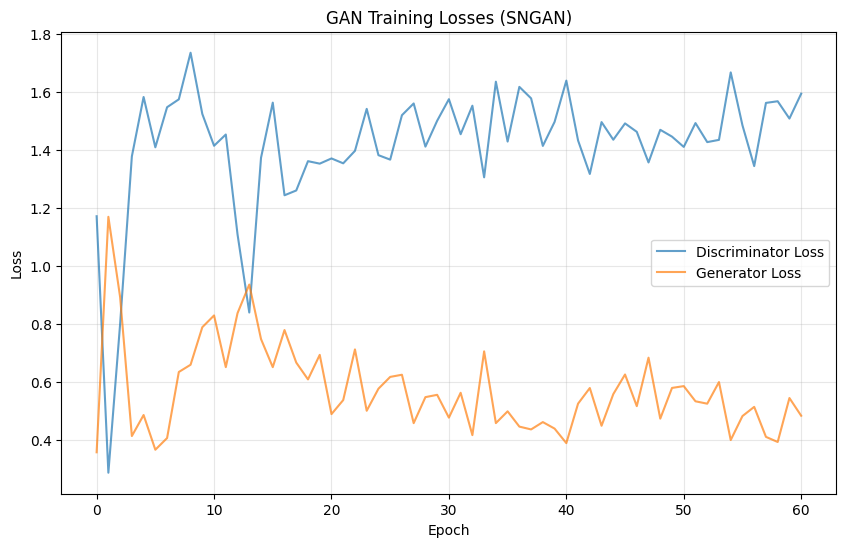


Cars3D Training Summary:
Final Discriminator Loss: 1.5943
Final Generator Loss: 0.4843
Average Discriminator Loss: 1.4182
Average Generator Loss: 0.5736


In [28]:
# Visualize Cars3D Training Progress
print("Plotting Cars3D training losses...")
trainer_cars3d.plot_losses()

# Show training history summary for Cars3D
if trainer_cars3d.history['d_loss'] and trainer_cars3d.history['g_loss']:
    print(f"\nCars3D Training Summary:")
    print(f"Final Discriminator Loss: {trainer_cars3d.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer_cars3d.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer_cars3d.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer_cars3d.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN on Cars3D...


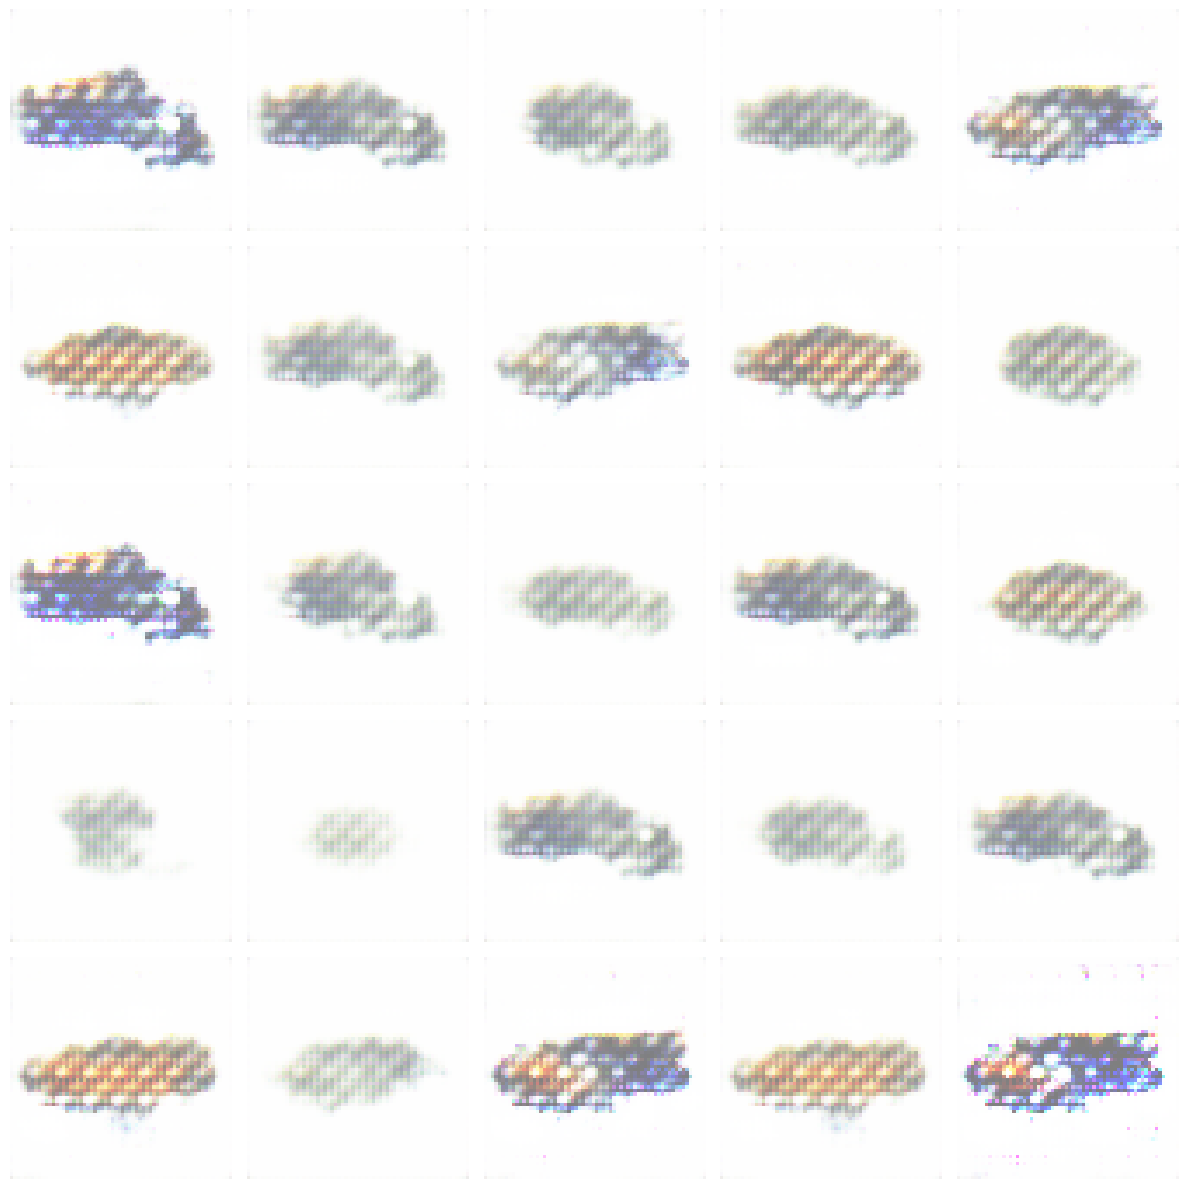

In [34]:
# Generate and Display Sample Images from Cars3D SN-GAN
print("Generating sample images from trained SN-GAN on Cars3D...")
trainer_cars3d.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))